In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
import scipy.stats as st
from pprint import pprint
from pandas import json_normalize
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#Liz's Hospital Dataframe

#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [3]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)



In [4]:
comb2_df.head(5)

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,337,11824,NaN,12161,209.0,42.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5769,52928,NaN,58697,1282.0,699.0,249.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2599,31952,NaN,34551,922.0,101.0,45.0,106,106,106,40,100,46,45,49,5,1
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,466,466,466,302,401,18,15,44,16,-17


<function matplotlib.pyplot.show(*args, **kw)>

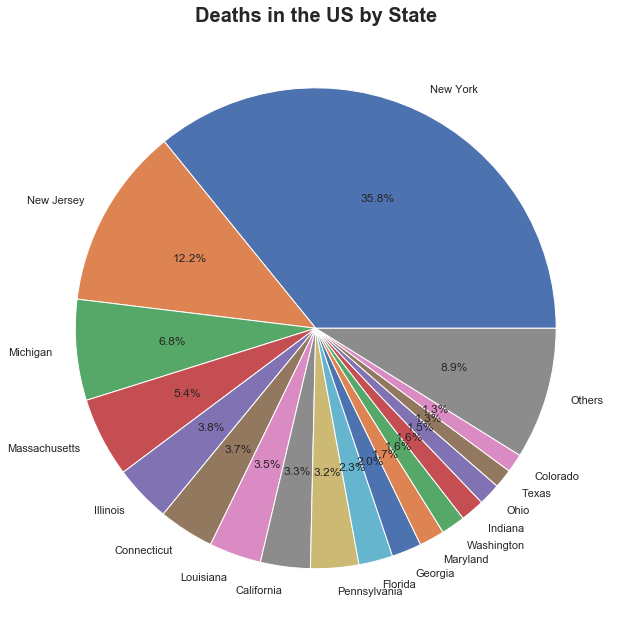

In [5]:
#Creation of new datframe for circle graph

#limit df to specific columns of interest
deathsbyState = comb2_df.loc[:,["State","Total Deaths"]]
#sort values so that in pie chart it goes from highest to lowest
deathsbyState.sort_values("Total Deaths", ascending = False,inplace = True)
#create an extra column to see percentages so that I can lump very small percentages into an other category
deathsbyState["Percent of Deaths in US"]=round(deathsbyState["Total Deaths"]/deathsbyState["Total Deaths"].sum()*100,2)
#reset index post sort
deathsbyState.reset_index(drop = True)
#Creating a variable to store all US deaths
USDeaths = deathsbyState["Total Deaths"].sum()
#limiting dataframe to only states accounting for at least 1% of the deaths in the US
deathsbyStatePie = deathsbyState[deathsbyState["Percent of Deaths in US"]>1]
#Finding the sum of the percents in the new df to get percent of those excluded for other category
PercentTop = deathsbyStatePie["Percent of Deaths in US"].sum()
#Calculating Percent of other category
PercentOther = (100 - float(PercentTop))
#Finding the deaths for the other category
OtherDeaths = USDeaths - deathsbyStatePie["Total Deaths"].sum()
#Inserting other row so the whole pie represents all US deaths
DeathsCircleChart = deathsbyStatePie.append({"State":"Others","Total Deaths":OtherDeaths,"Percent of Deaths in US":PercentOther}, ignore_index = True)

#Plotting storing and showing Pie Chart
labels = DeathsCircleChart["State"]
sizes = DeathsCircleChart ["Total Deaths"]
fig1, ax1 = plt.subplots(figsize=(9, 9))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')

plt.title("Deaths in the US by State",fontdict ={'fontsize': 20,
        'fontweight' : 700})

plt.tight_layout()
plt.savefig("PNG Folder/DeathPie.png")
plt.show

The New York and New Jersey region are dominating.  The Northeast is dominating a large chunk of the deaths in the US.  State deaths by region.

In [6]:
# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)

#Create Data Frame to display increase in cases over time of top 10 States in total current cases
cases=final_df.pivot( index="date",columns="state",values = "cases")
cases = cases.fillna(0)
top_cases =cases[["New York", "New Jersey","Massachusetts","California","Illinois","Pennsylvania","Michigan","Florida","Connecticut","Louisiana"]]

#Create Data Frame to display increase in deaths over time of top 10 States in total current deaths
death_df = final_df[final_df["Deaths"]>0]
death_plot = death_df.pivot( index="date",columns="state",values = "Deaths")
top_deaths = death_plot[["New York", "New Jersey","Massachusetts","California","Illinois","Pennsylvania","Michigan","Florida","Connecticut","Louisiana"]]


<function matplotlib.pyplot.show(*args, **kw)>

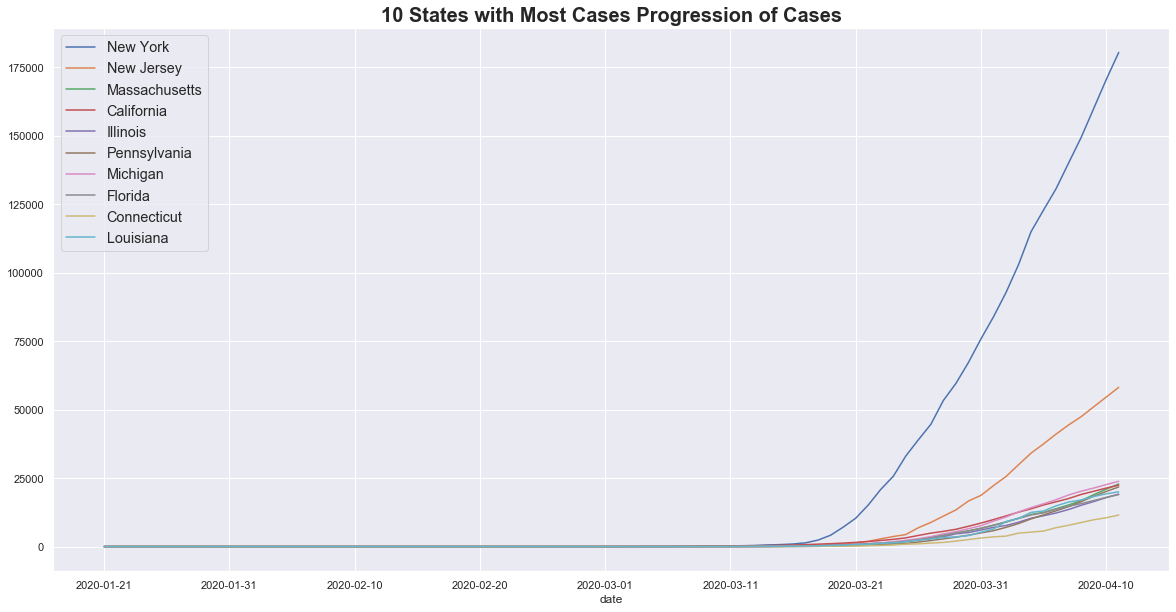

In [7]:

top_cases.plot.line(figsize = (20,10))
plt.legend(loc = 'upper left',fontsize ="large")
plt.title("10 States with Most Cases Progression of Cases",fontdict ={'fontsize': 20,
        'fontweight' : 700})
plt.savefig("PNG Folder/CaseOverTime.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

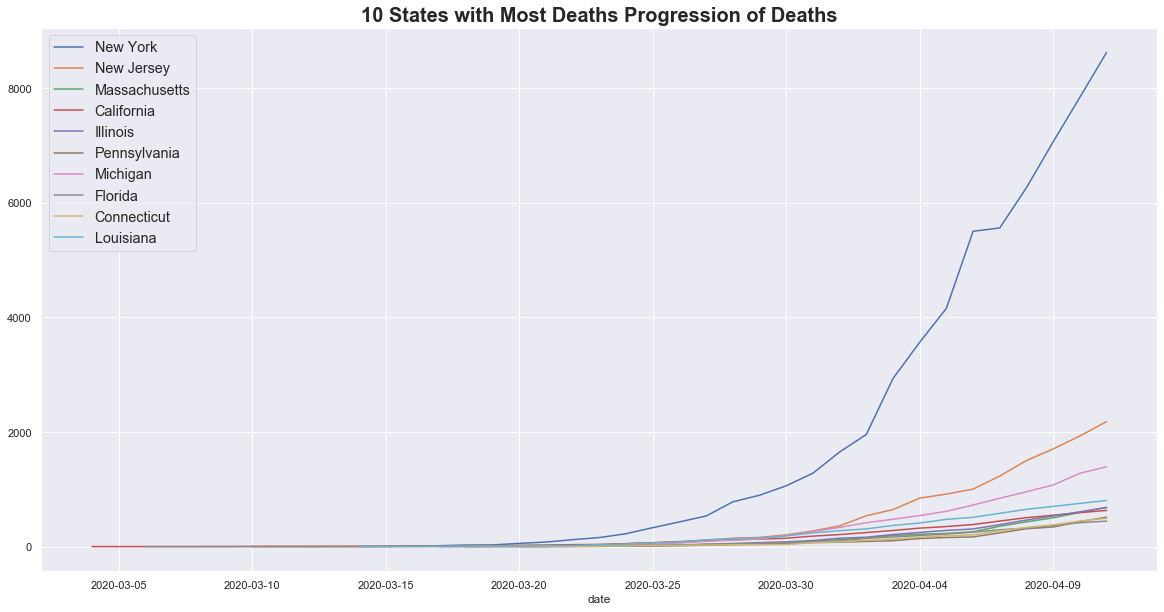

In [8]:

top_deaths.plot.line(figsize = (20,10))
plt.legend(loc = 'upper left',fontsize ="large")
plt.title("10 States with Most Deaths Progression of Deaths",fontdict ={'fontsize': 20,
        'fontweight' : 700})

plt.savefig("PNG Folder/DeathsOverTime.png")
plt.show

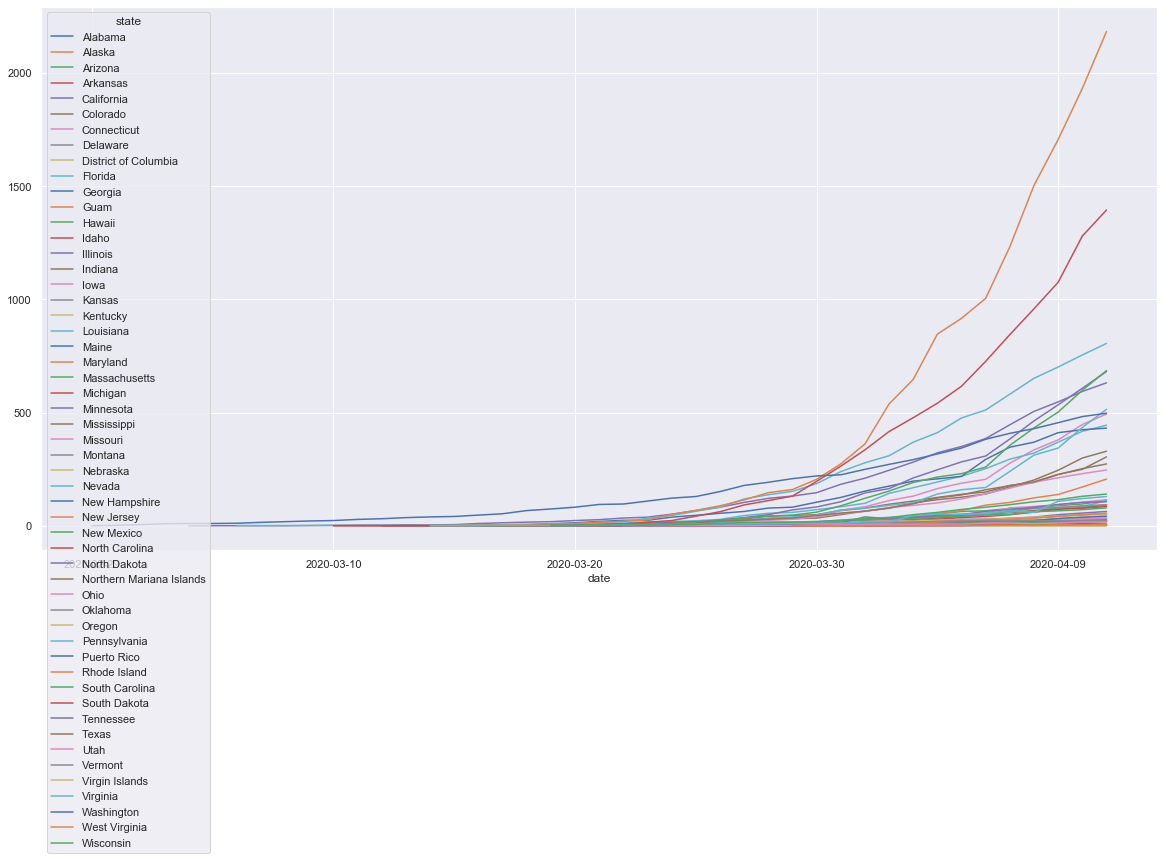

In [9]:
death_wo_NY = final_df[(final_df["Deaths"]>0) & (final_df["state"]!="New York")]
death_wo_NY = death_wo_NY.pivot( index="date",columns="state",values = "Deaths")
death_wo_NY.plot.line(figsize = (20,10))
plt.show
plt.savefig("PNG Folder/DeathsOverTimewoNY.png")

In [10]:
agg_time = pd.merge(final_df, States_Most_Aggressive_Measures_df, how = 'left', left_on = 'state', right_on = "State")
agg_time.head()

,date,state,cases,Deaths,Overall Rank,State,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,2020-01-21,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
1,2020-01-22,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
2,2020-01-23,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
3,2020-01-24,Illinois,1,0,23.0,Illinois,25.0,16.0,48.0,-5.0
4,2020-01-24,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0


In [11]:
tests_df.head()

,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0
1,Alaska,337,11824,NaN,12161,209.0,42.0,9.0
2,Arizona,5769,52928,NaN,58697,1282.0,699.0,249.0
3,Arkansas,2599,31952,NaN,34551,922.0,101.0,45.0
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0


In [12]:
#Read in the Poverty Data File and Population Data File
df = pd.read_csv("CSV Folder/Poverty by state 2018.csv")
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")

#Select and rename columns of interest for merging
df.rename( columns={'Unnamed: 0':'State'}, inplace=True )
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})

#Merge the poverty and population df's and then merge with the state tests_df
poverty_df = pop_df.merge(df,how = 'inner',on = "State")
pov_death = tests_df.merge(poverty_df,how = 'inner', on = "State")

#Sort df by percent in poverty
pov_death.sort_values("Percent in Poverty (All)", ascending = False).head()
bins = (0,10,11,12,13,14,15,16,17,20)
labels = ("< 10","10-10.99","11-11.99","12-12.99","13-13.99","14-14.99","15-15.99","16-16.99","> 17")
pov_death["Poverty Groups"] = pd.cut(x = pov_death["Percent in Poverty (All)"], bins = bins, labels = labels)
pov_death.rename(columns = {"death":"Deaths","positive":"Cases","negative":"Negative Tests","totalTestResults":"Total Tests"},inplace=True)
pov_death.head()

,State,Cases,Negative Tests,pending,Total Tests,recovered,hospitalizedCurrently,Deaths,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0,4903185,3814879,77.8,16.8,16.5,17.1,23.9,23.2,24.6,16-16.99
1,Alaska,337,11824,NaN,12161,209.0,42.0,9.0,731545,551562,75.4,11.1,10.5,11.7,14.5,13.4,15.6,11-11.99
2,Arizona,5769,52928,NaN,58697,1282.0,699.0,249.0,7278717,5638481,77.5,14.1,13.8,14.4,20.4,19.7,21.1,14-14.99
3,Arkansas,2599,31952,NaN,34551,922.0,101.0,45.0,3017804,2317649,76.8,16.8,16.3,17.3,23.8,22.8,24.8,16-16.99
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,39512223,30617582,77.5,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


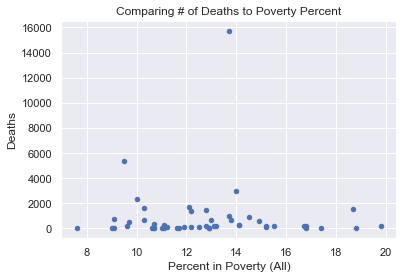

In [13]:
pov_death.plot.scatter("Percent in Poverty (All)","Deaths")
plt.title("Comparing # of Deaths to Poverty Percent")
plt.savefig("PNG Folder/PovertyVsDeaths.png")



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


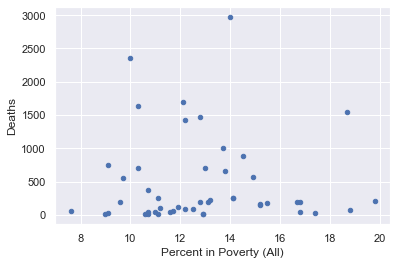

In [14]:
pov_wo_NY = pov_death[(pov_death["State"] != "New York")&(pov_death["State"] !="New Jersey")]
pov_wo_NY.plot.scatter("Percent in Poverty (All)","Deaths")

In [15]:
pov_death

,State,Cases,Negative Tests,pending,Total Tests,recovered,hospitalizedCurrently,Deaths,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0,4903185,3814879,77.8,16.8,16.5,17.1,23.9,23.2,24.6,16-16.99
1,Alaska,337,11824,NaN,12161,209.0,42.0,9.0,731545,551562,75.4,11.1,10.5,11.7,14.5,13.4,15.6,11-11.99
2,Arizona,5769,52928,NaN,58697,1282.0,699.0,249.0,7278717,5638481,77.5,14.1,13.8,14.4,20.4,19.7,21.1,14-14.99
3,Arkansas,2599,31952,NaN,34551,922.0,101.0,45.0,3017804,2317649,76.8,16.8,16.3,17.3,23.8,22.8,24.8,16-16.99
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,39512223,30617582,77.5,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99
5,Colorado,11262,41062,NaN,52324,NaN,873.0,552.0,5758736,4499217,78.1,9.7,9.5,9.9,12.1,11.4,12.8,< 10
6,Connecticut,23100,48397,NaN,71497,NaN,1947.0,1639.0,3565287,2837847,79.6,10.3,10.0,10.6,13.8,13.1,14.5,10-10.99
7,Delaware,3308,13604,NaN,16912,643.0,290.0,92.0,973764,770192,79.1,12.2,11.6,12.8,17.6,16.4,18.8,12-12.99
8,Florida,29648,271499,1329.0,301147,NaN,NaN,1006.0,21477737,17247808,80.3,13.7,13.5,13.9,20.0,19.5,20.5,13-13.99
9,Georgia,21883,79550,NaN,101433,NaN,NaN,881.0,10617423,8113542,76.4,14.5,14.2,14.8,21.0,20.4,21.6,14-14.99


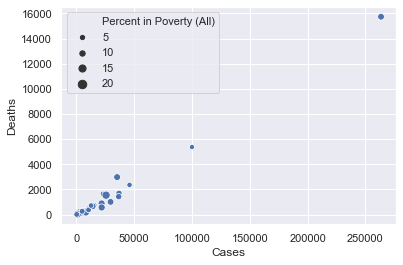

In [16]:
ax= sns.scatterplot(x="Cases", y ="Deaths", size ="Percent in Poverty (All)", data= pov_death)

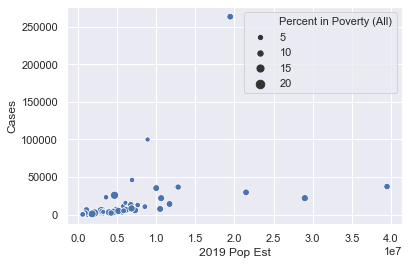

In [33]:
ax= sns.scatterplot(x="2019 Pop Est", y ="Cases",size = "Percent in Poverty (All)",data= pov_death)

In [18]:
grades = pd.read_csv("CSV Folder/StayatHomeGrades.txt")
grades.head()
pov_death = pov_death.merge(grades, how = 'inner', on = "State" )
#pov_death.drop(columns = ["Grade_x","Grade_y"], inplace = True)

In [32]:
grade = pov_death.sort_values("Grade")
grade.head()

,State,Cases,Negative Tests,pending,Total Tests,recovered,hospitalizedCurrently,Deaths,2019 Pop Est,2019 18+,...,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups,Grade,Date Announced,Effective Date
27,Nevada,4208,30541,NaN,34749,NaN,NaN,195.0,3080156,2387517,...,13.1,12.7,13.5,18.4,17.6,19.2,13-13.99,A-,April 1,April 1
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,39512223,30617582,...,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99,B,March 19,March 19
21,Michigan,35291,93030,NaN,128321,3237.0,3611.0,2977.0,9986857,7842924,...,14.0,13.8,14.2,19.3,18.8,19.8,13-13.99,B,March 23,March 24
44,Vermont,825,13027,NaN,13852,1710.0,44.0,43.0,623989,509984,...,10.7,10.1,11.3,12.2,11.1,13.3,10-10.99,B-,March 24,March 24
5,Colorado,11262,41062,NaN,52324,NaN,873.0,552.0,5758736,4499217,...,9.7,9.5,9.9,12.1,11.4,12.8,< 10,B-,March 26,March 26


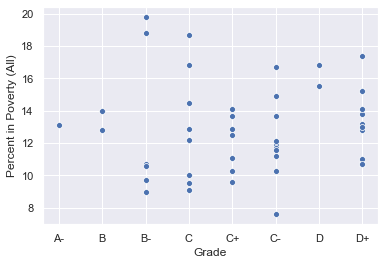

In [20]:
ax= sns.scatterplot(x="Grade", y ="Percent in Poverty (All)",data= grade )

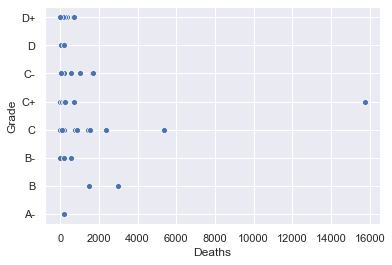

In [21]:
ax= sns.scatterplot(x="Deaths", y ="Grade",data= grade)

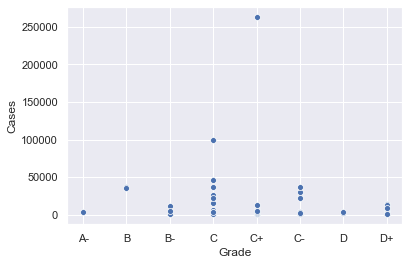

In [22]:
ax= sns.scatterplot(x="Grade", y ="Cases",data= grade)

In [23]:
avg_grade = grade.groupby("Grade")

In [24]:
avg_grade["Deaths"].mean()

Grade
A-     195.000000
B     2223.000000
B-     149.000000
C     1265.600000
C+    2157.250000
C-     544.200000
D      112.000000
D+     254.454545
Name: Deaths, dtype: float64

In [25]:
avg_grade["Cases"].mean()

Grade
A-     4208.000000
B     36330.000000
B-     3458.333333
C     25921.200000
C+    36799.500000
C-    12595.600000
D      2808.000000
D+     6783.000000
Name: Cases, dtype: float64

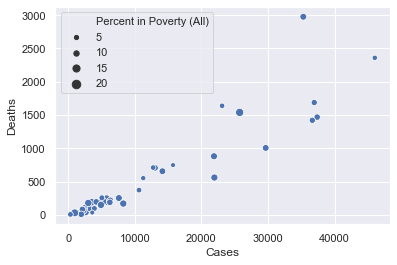

In [26]:
ax= sns.scatterplot(x="Cases", y ="Deaths", size ="Percent in Poverty (All)", data= pov_wo_NY)

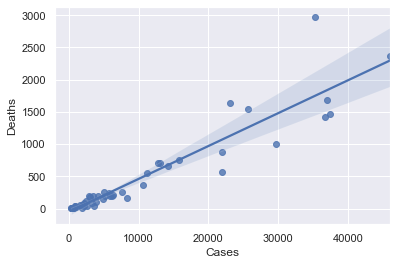

In [27]:
ax = sns.regplot(x="Cases", y ="Deaths", fit_reg = True, data= pov_wo_NY)

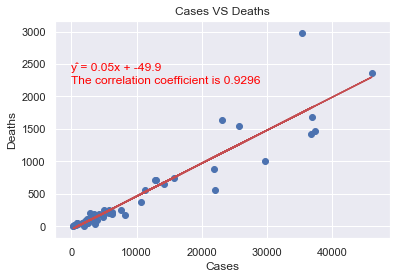

In [28]:
x_values = pov_wo_NY['Cases']
y_values = pov_wo_NY['Deaths']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_wo_NY['Cases'],pov_wo_NY['Deaths'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (18,2400),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(18,2200),fontsize = 12, color = 'red')

#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("Cases VS Deaths")
plt.xlabel('Cases')
plt.ylabel('Deaths')
plt.show()

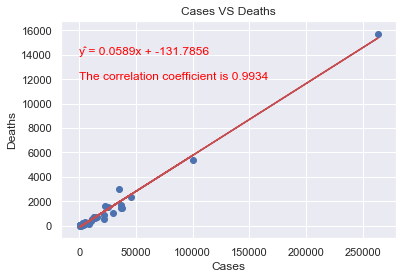

In [53]:
x_values = pov_death['Cases']
y_values = pov_death['Deaths']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_death['Cases'],pov_death['Deaths'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,4)) + "x + " + str(round(intercept,4))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (18,14000),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(18,12000),fontsize = 12, color = 'red')

#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("Cases VS Deaths")
plt.xlabel('Cases')
plt.ylabel('Deaths')
plt.show()

In [30]:
pov_death.head()

,State,Cases,Negative Tests,pending,Total Tests,recovered,hospitalizedCurrently,Deaths,2019 Pop Est,2019 18+,...,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups,Grade,Date Announced,Effective Date
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0,4903185,3814879,...,16.8,16.5,17.1,23.9,23.2,24.6,16-16.99,C,April 3,April 4
1,Alaska,337,11824,NaN,12161,209.0,42.0,9.0,731545,551562,...,11.1,10.5,11.7,14.5,13.4,15.6,11-11.99,C+,March 27,March 28
2,Arizona,5769,52928,NaN,58697,1282.0,699.0,249.0,7278717,5638481,...,14.1,13.8,14.4,20.4,19.7,21.1,14-14.99,C+,March 30,March 31
3,Arkansas,2599,31952,NaN,34551,922.0,101.0,45.0,3017804,2317649,...,16.8,16.3,17.3,23.8,22.8,24.8,16-16.99,D,–,–
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,39512223,30617582,...,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99,B,March 19,March 19


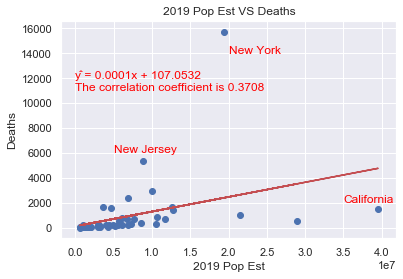

In [49]:
x_values = pov_death['2019 Pop Est']
y_values = pov_death['Deaths']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_death['2019 Pop Est'],pov_death['Deaths'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,4)) + "x + " + str(round(intercept,4))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (0,12000),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(0,11000),fontsize = 12, color = 'red')
plt.annotate("New York", (20000000,14000),fontsize =12, color = 'red')
plt.annotate("California", (35000000,2000),fontsize =12, color = 'red')
plt.annotate("New Jersey", (5000000,6000),fontsize =12, color = 'red')

#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("2019 Pop Est VS Deaths")
plt.xlabel('2019 Pop Est')
plt.ylabel('Deaths')
plt.show()

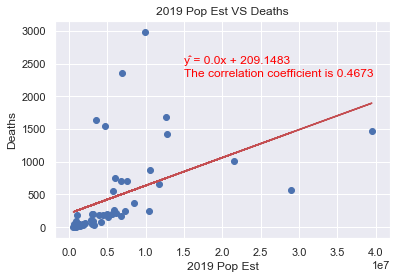

In [52]:
x_values = pov_wo_NY['2019 Pop Est']
y_values = pov_wo_NY['Deaths']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_wo_NY['2019 Pop Est'],pov_wo_NY['Deaths'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,4)) + "x + " + str(round(intercept,4))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (15000000,2500),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(15000000,2300),fontsize = 12, color = 'red')


#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("2019 Pop Est VS Deaths")
plt.xlabel('2019 Pop Est')
plt.ylabel('Deaths')
plt.show()

In [41]:
pov_death.sort_values("Cases",ascending = False)

,State,Cases,Negative Tests,pending,Total Tests,recovered,hospitalizedCurrently,Deaths,2019 Pop Est,2019 18+,...,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups,Grade,Date Announced,Effective Date
31,New York,263460,432460,NaN,695920,23887.0,15021.0,15740.0,19453561,15425262,...,13.7,13.5,13.9,18.8,18.3,19.3,13-13.99,C+,March 20,March 22
29,New Jersey,99989,100159,NaN,200148,NaN,7240.0,5368.0,8882190,6943612,...,9.5,9.3,9.7,13.5,12.9,14.1,< 10,C,March 20,March 21
20,Massachusetts,46023,149053,NaN,195076,NaN,3890.0,2360.0,6892503,5539703,...,10.0,9.8,10.2,12.4,11.7,13.1,< 10,C,March 23,March 24
4,California,37369,444728,NaN,482097,NaN,4929.0,1469.0,39512223,30617582,...,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99,B,March 19,March 19
12,Illinois,36934,136382,NaN,173316,NaN,4877.0,1688.0,12671821,9853946,...,12.1,11.9,12.3,16.2,15.7,16.7,12-12.99,C-,March 20,March 21
37,Pennsylvania,36647,142061,NaN,178708,NaN,2750.0,1421.0,12801989,10167376,...,12.2,12.0,12.4,16.7,16.2,17.2,12-12.99,C,March 23,April 1
21,Michigan,35291,93030,NaN,128321,3237.0,3611.0,2977.0,9986857,7842924,...,14.0,13.8,14.2,19.3,18.8,19.8,13-13.99,B,March 23,March 24
8,Florida,29648,271499,1329.0,301147,NaN,NaN,1006.0,21477737,17247808,...,13.7,13.5,13.9,20.0,19.5,20.5,13-13.99,C-,April 1,April 3
17,Louisiana,25739,117576,NaN,143315,NaN,1727.0,1540.0,4648794,3561164,...,18.7,18.3,19.1,26.5,25.6,27.4,> 17,C,March 22,March 23
6,Connecticut,23100,48397,NaN,71497,NaN,1947.0,1639.0,3565287,2837847,...,10.3,10.0,10.6,13.8,13.1,14.5,10-10.99,C-,March 20,March 23
